In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>")) 

# Load Data

In [9]:
# Load index mapping 
with open('data/movie_to_idx.pkl', 'rb') as handle:
    movie2idx = pickle.load(handle)

#Load movies data
movies = pd.read_csv('data/movie_demographics.csv', index_col=0)

#Use ratings data to downsample tags data to only movies with ratings 
ratings = pd.read_csv('data/ml-20m/ratings.csv')

ratings = pd.merge(movies, ratings, on="movieId", how="right")
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])
print(ratings.shape)
print("There are {} users.".format(len(ratings.userId.unique())))
print("There are {} movies.".format(len(ratings.movieId.unique())))
ratings.head()

(20000263, 8)
There are 138493 users.
There are 26744 movies.


,movieId,title,genres,ratings_count,avg_rating,userId,rating,timestamp
0,227,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,8520.0,3.95223,3,4.0,944919407
1,227,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,8520.0,3.95223,6,5.0,858275452
2,227,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,8520.0,3.95223,8,4.0,833981871
3,227,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,8520.0,3.95223,10,4.0,943497887
4,227,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,8520.0,3.95223,11,4.5,1230858821


In [10]:
#ratings = ratings.sample(500000)
#remove users that rates less than n things. 
ratings = ratings.groupby('userId').filter(lambda x: len(x) >= 10)
print("There are {} users.".format(len(ratings.userId.unique())))
#remove movies that only occure once
#ratings = ratings.groupby('movieId').filter(lambda x: len(x) > 50)
print("There are {} movies.".format(len(ratings.movieId.unique())))

There are 138493 users.
There are 26744 movies.


In [11]:
ratings = ratings.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
user_index = ratings.index.tolist()
movie_index = ratings.columns.tolist()

In [12]:
print(ratings.shape)
ratings.head(3)

(26744, 138493)


userId,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
movieId,,,,,,,,,,,,,,,,,,,,,
0,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0
1,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2,3.5,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0


# SVD

In [13]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=500)
latent_matrix = svd.fit_transform(ratings)
print(latent_matrix.shape)

(26744, 500)


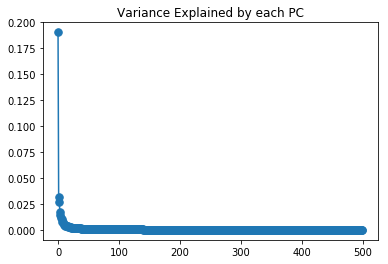

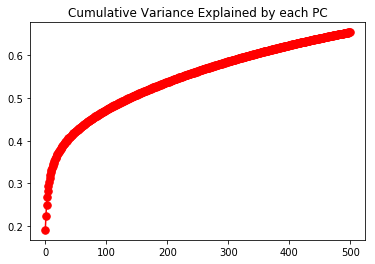

In [14]:
# plot var expalined to iuck number of latent dimensions to use
expl = svd.explained_variance_ratio_
plt.plot(expl, '.-', ms=15)
plt.title('Variance Explained by each PC');
plt.show()

plt.plot(np.cumsum(expl), '.-', ms=15, color='red')
plt.title('Cumulative Variance Explained by each PC');
plt.show()

In [15]:
n = 100 #number of latent dimensions to keep
latent_matrix_df = pd.DataFrame(latent_matrix[:,0:n], index=ratings.index.tolist())
print(latent_matrix_df.shape)

(26744, 100)


In [16]:
latent_matrix_df.to_pickle('data/svd_ratings_embeddings.pkl')